# Ejemplo de simulación discreta: Sector de terminado, Tesla
---
- Autor: **[Rodrigo Maranzana](https://www.linkedin.com/in/rodrigo-maranzana/)**
- Año: **2020**
- Licencia: **[MIT License](https://github.com/harb-OR/casos_practicos/blob/master/LICENSE)**
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción-al-caso" data-toc-modified-id="Introducción-al-caso-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción al caso</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Objetivo-del-estudio:" data-toc-modified-id="Objetivo-del-estudio:-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Objetivo del estudio:</a></span></li><li><span><a href="#Las-especificaciones-de-las-máquinas-son-las-siguientes:" data-toc-modified-id="Las-especificaciones-de-las-máquinas-son-las-siguientes:-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Las especificaciones de las máquinas son las siguientes:</a></span></li><li><span><a href="#Sobre-las-llegadas:" data-toc-modified-id="Sobre-las-llegadas:-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Sobre las llegadas:</a></span></li><li><span><a href="#El-layout-de-planta-sigue-la-siguiente-configuración:" data-toc-modified-id="El-layout-de-planta-sigue-la-siguiente-configuración:-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>El layout de planta sigue la siguiente configuración:</a></span></li><li><span><a href="#Datos-adicionales:" data-toc-modified-id="Datos-adicionales:-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Datos adicionales:</a></span></li></ul></li></ul></li><li><span><a href="#Resolución" data-toc-modified-id="Resolución-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Resolución</a></span><ul class="toc-item"><li><span><a href="#Simulador-de-eventos-discretos:" data-toc-modified-id="Simulador-de-eventos-discretos:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Simulador de eventos discretos:</a></span></li></ul></li><li><span><a href="#Log-de-eventos:" data-toc-modified-id="Log-de-eventos:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Log de eventos:</a></span></li><li><span><a href="#Resultados" data-toc-modified-id="Resultados-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Resultados</a></span></li><li><span><a href="#Ideas-sobre-conclusiones,-a-completar-en-el-curso:" data-toc-modified-id="Ideas-sobre-conclusiones,-a-completar-en-el-curso:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ideas sobre conclusiones, a completar en el curso:</a></span></li></ul></div>

<img src="tesla_banner.jpg">

## Introducción al caso
La línea de ensamblaje de la automotriz Tesla que cuenta con un sector de prueba de performance. El objetivo es tomar los autos salidos de la línea de ensamblaje, testear su performance en un banco de pruebas y luego hacer un control final sobre la terminación.

Existen dos máquinas en paralelo que realizan el testeo. Si bien son idénticas en el tipo de trabajo que realizan, cada una tiene sus tiempos de producción propios. Al concluir el trabajo en el banco, el auto pasa a un sector de revisado manual, donde varios operarios hacen una apreciación cualitativa del usuario como la apertura de puertas o terminación visual en general.

#### Objetivo del estudio:
Mediante la simulación industrial se busca concluir sobre la performance del sector, identificando indicadores sobre la cantidad de unidades en cada fila de espera que suelen tener problemas de cuello de botella.

#### Las especificaciones de las máquinas son las siguientes:
* Banco de pruebas 1 (nombre m1): el tiempo de proceso sigue una distribución normal; media: 0.04 hr/u, desvío: 10% media.
* Banco de pruebas 2 (nombre m2): el tiempo de proceso sigue una distribución normal; media: 0.10 hr/u, desvío: 10% media.
* Control cualitativo (nombre m3): el tiempo de proceso sigue una distribución normal; media: 0.03 hr/u, desvío: 15% media.

#### Sobre las llegadas:
Si bien existen muchos modelos de Tesla, no es importante para la simulación, por lo tanto, se deben tomar todas las unidades como el mismo auto. No se conoce exactamente cuántos autos y en qué momento va a ingresar a testeo por las fluctuaciones constantes de la línea. Se decid modelizar las llegadas con una distribución exponencial con tasa de llegadas de: 33 unidades/hr.

#### El layout de planta sigue la siguiente configuración:
<img src="circuito.jpg" width="500">

#### Datos adicionales:
* La política de las filas de espera es FIFO.
* Si la m1 y m2 están vacías y un vehículo requiere su servicio, se va a elegir la que tenga una menor fila a la salida.
* Cuando la m3 requiera unidades, va a elegirlas de la fila de salida más numerosa de las máquinas m1 y m2.
* Se busca codificar los productos para futuros indicadores de tiempos.
* El tiempo de simulación es de 4 horas, coincide con un turno de producción.


## Resolución

En primer lugar, importamos las librerías necesarias para el cálculo:

In [1]:
import numpy as np
from numpy.random import exponential, normal
import matplotlib.pyplot as plt
import pandas as pd

Definimos los parámetros de las distribuciones y otros atributos fijos.

In [2]:
# Parámetros de llegadas:
media_llegada = 33 # u/hr
beta = 1/media_llegada # hr/u

# Parámetros de procesamiento en máquina 1:
mu_m1 = 1/25 # hr/u
sigma_m1 = mu_m1 * 0.1 # hr/u

# Parámetros de procesamiento en máquina 2:
mu_m2 = 1/10 # hr/u
sigma_m2 = mu_m2 * 0.1 # hr/u

# Parámetros de procesamiento en máquina 3:
mu_m3 = 1/33 # hr/u
sigma_m3 = mu_m3 * 0.15 # hr/u

codigos_productos = range(0, 20000)
gen_codigo_productos = iter(codigos_productos)

Podemos detectar cuatro tipo de eventos en el tiempo de simulación:
* Llegada de una unidad
* Salida de una unidad de la máquina 1
* Salida de una unidad de la máquina 2
* Salida de una unidad de la máquina 3

Cualquier otra acción, no la reconocemos como evento ya que no se produce en un tiempo diferente. Por ejemplo, podríamos pensar que "entrada en fila 0" es un evento único. Sin embargo, es una acción inmediatamente posterior a "llegada de una unidad" y no tiene tiempo propio. Por lo tanto, la entrada en fila0, forma parte del evento de llegada.

Los tiempos de los eventos los vamos a generar con las distribuciones mencionadas más arriba en funciones. De esta manera es más fácil hacer su llamado en el simulador.

In [3]:
# Funciones pertenecientes a eventos:
def generar_llegada(t_global, generador_codigo_productos):
    t_llegada = exponential(beta) + t_global
    nuevo_n_producto = next(generador_codigo_productos)
    return t_llegada, nuevo_n_producto

def generar_salida_m1(t_global):
    t_salida = normal(mu_m1, sigma_m1) + t_global
    return t_salida

def generar_salida_m2(t_global):
    t_salida = normal(mu_m2, sigma_m2) + t_global
    return t_salida
    
def generar_salida_m3(t_global):
    t_salida = normal(mu_m3, sigma_m3) + t_global
    return t_salida

El manejo de las filas de espera va a estar a cargo de una función que maneja los productos siguiendo una política FIFO. Vamos a determinar una función para cada acción que ocurra en una fila. Como indicamos anteriormente estas acciones van a pertenecer a alguno de los cuatro eventos descriptos arriba.

In [4]:
import heapq

fila0 = []
fila1 = []
fila2 = []

def almacenar_producto_en_fila0(n_producto):
    heapq.heappush(fila0, n_producto)
    
def obtener_producto_de_fila0():
    return heapq.heappop(fila0)
    
def almacenar_producto_en_fila1(n_producto):
    heapq.heappush(fila1, n_producto)
    
def obtener_producto_de_fila1():
    return heapq.heappop(fila1)

def almacenar_producto_en_fila2(n_producto):
    heapq.heappush(fila2, n_producto)
    
def obtener_producto_de_fila2():
    return heapq.heappop(fila2)

### Simulador de eventos discretos:

La primer tarea que tenemos antes de crear el simulador es manejar los eventos con su propia fila de espera. Ésta no tiene nada que ver con las filas del ejemplo (fila0, fila1 y fila2). Nos referimos a una fila propia del simulador, es decir un recurso computacional para manejar los eventos. Nuevamente la vamos a manejar mediante funciones:

In [5]:
fila_simulador = []

def ingresar_a_fila_simulador(t, tipo_evento, n_producto):
    heapq.heappush(fila_simulador, (t, tipo_evento, n_producto))
    
def recuperar_de_fila_simulador():
    return heapq.heappop(fila_simulador)

Creamos una tabla representada como un diccionario de Python, para poder hacer un registro de los eventos. Anotamos: el tiempo, tipo de evento y número de producto asociado al evento.

Además generamos una lista para guardar el estado de cada fila en los tiempos de simulación.

In [6]:
tabla_eventos = {'tiempo': [], 'evento': [], 'producto': []}

estado_fila0 = []
estado_fila1 = []
estado_fila2 = []

Inicializamos las variables del simulador.

In [7]:
t_global = 0 # Tiempo actual de simulación.
t_corte = 4 # Tiempo máximo de simulación.

maquina_libre = {'m1': True, 'm2': True, 'm3': True} # Estado libre de cada máquina: True (libre), False (en uso)
n_producto = 0 # Número de producto en el tiempo actual de simulación.

A continuación escribimos la estructura del simulador. Está dividida en dos partes:
* Tomar un nuevo evento de la fila y registrar en tabla.
* Según el tipo de evento, entrar en un bloque y disparar una acción.

Todo está contenido en un "while loop" que está pisado, esto quiere decir que se va a repetir hasta el infinito. La condición de corte la podemos encontrar al principio, en donde indica que se repite siempre que no supere el tiempo de corte asignado.

In [8]:
################## SIMULADOR #############################
# Inicio
t_llegada, n_nuevo_producto = generar_llegada(t_global, gen_codigo_productos)
ingresar_a_fila_simulador(t_llegada, 'nueva_unidad', n_nuevo_producto)

while True:
    # Sacar evento de la fila de eventos:
    nuevo_evento = recuperar_de_fila_simulador()
    t_global = nuevo_evento[0]
    if t_global > t_corte:
        break
    tipo_evento = nuevo_evento[1]
    n_producto = nuevo_evento[2]
    
    # Agregar eventos a la tabla de seguimiento:
    tabla_eventos['tiempo'].append(t_global)
    tabla_eventos['evento'].append(tipo_evento)
    tabla_eventos['producto'].append(n_producto)
    
   ################ EVENTO: llegada de un vehículo ################
    if tipo_evento == 'nueva_unidad':
        if len(fila1) < len(fila2):
            if maquina_libre['m1']:
                # Se elige máquina 1:
                maquina_libre['m1'] = False
                t_salida = generar_salida_m1(t_global)
                ingresar_a_fila_simulador(t_salida, 'm1_out', n_producto)
                
            elif maquina_libre['m2']:
                # Se elige máquina 2:
                maquina_libre['m2'] = False
                t_salida = generar_salida_m2(t_global)
                ingresar_a_fila_simulador(t_salida, 'm2_out', n_producto)
            else:
                almacenar_producto_en_fila0(n_producto)
        else:
            if maquina_libre['m2']:
                # Se elige máquina 2:
                maquina_libre['m2'] = False
                t_salida = generar_salida_m2(t_global)
                ingresar_a_fila_simulador(t_salida, 'm2_out', n_producto)
            elif maquina_libre['m1']:
                # Se elige máquina 1:
                maquina_libre['m1'] = False
                t_salida = generar_salida_m1(t_global)
                ingresar_a_fila_simulador(t_salida, 'm1_out', n_producto)
            else:
                almacenar_producto_en_fila0(n_producto)
                
        t_llegada, n_nuevo_producto = generar_llegada(t_global, gen_codigo_productos)
        ingresar_a_fila_simulador(t_llegada, 'nueva_unidad', n_nuevo_producto)
    
    ################ EVENTO: salida de un vehículo de máquina 1 ################
    if tipo_evento == 'm1_out':
        # definir destino de salida:
        if maquina_libre['m3']:
            t_salida = generar_salida_m3(t_global)
            ingresar_a_fila_simulador(t_salida, 'm3_out', n_producto)
            maquina_libre['m3'] = False
        else:
            almacenar_producto_en_fila1(n_producto)
        
        # ingresar nuevo producto:
        if len(fila0) > 0:
            n_producto = obtener_producto_de_fila0()
            t_salida = generar_salida_m1(t_global)
            ingresar_a_fila_simulador(t_salida, 'm1_out', n_producto)
        else:
            maquina_libre['m1'] = True
    
    ################ EVENTO: salida de un vehículo de máquina 2 ################
    if tipo_evento == 'm2_out':
        # definir destino de salida:
        if maquina_libre['m3']:
            t_salida = generar_salida_m3(t_global)
            ingresar_a_fila_simulador(t_salida, 'm3_out', n_producto)
            maquina_libre['m3'] = False
        else:
            almacenar_producto_en_fila2(n_producto)
        
        # ingresar nuevo producto:
        if len(fila0) > 0:
            n_producto = obtener_producto_de_fila0()
            t_salida = generar_salida_m2(t_global)
            ingresar_a_fila_simulador(t_salida, 'm2_out', n_producto)
        else:
            maquina_libre['m2'] = True
    
    ################ EVENTO: salida de un vehículo de máquina 3 ################
    if tipo_evento == 'm3_out':
        # ingresar nuevo producto:
        if len(fila1) > len(fila2):
            n_producto = obtener_producto_de_fila1()
            t_salida = generar_salida_m3(t_global)
            ingresar_a_fila_simulador(t_salida, 'm3_out', n_producto)
        elif len(fila2) > 0:
            n_producto = obtener_producto_de_fila2()
            t_salida = generar_salida_m3(t_global)
            ingresar_a_fila_simulador(t_salida, 'm3_out', n_producto)
        else:
            maquina_libre['m3'] = True
    
    ####### Recolectar datos ##########
    estado_fila0.append(len(fila0))
    estado_fila1.append(len(fila1))
    estado_fila2.append(len(fila2))

## Log de eventos:
Construimos un log de eventos. Esto es una tabla que informa el tiempo, tipo de evento y número de producto asociado al evento:

In [9]:
log = pd.DataFrame(tabla_eventos)
from IPython.display import display, HTML
print('\n ######### Log de eventos ###############')
display(HTML(log.to_html()))


 ######### Log de eventos ###############


,tiempo,evento,producto
0,0.015994,nueva_unidad,0
1,0.064310,nueva_unidad,1
2,0.101958,m1_out,1
3,0.116578,m2_out,0
4,0.133281,m3_out,1
5,0.133383,nueva_unidad,2
6,0.149710,nueva_unidad,3
7,0.160706,nueva_unidad,4
8,0.162255,m3_out,0
9,0.186807,m1_out,3


Agrupamos el log para poder visualizar la historia de cada producto:

In [10]:
group = log.groupby('producto')
for key, value in group:
    print('\n\n producto: %s \n' %key, value[['tiempo', 'evento']])



 producto: 0 
      tiempo        evento
0  0.015994  nueva_unidad
3  0.116578        m2_out
8  0.162255        m3_out


 producto: 1 
      tiempo        evento
1  0.064310  nueva_unidad
2  0.101958        m1_out
4  0.133281        m3_out


 producto: 2 
       tiempo        evento
5   0.133383  nueva_unidad
12  0.217765        m2_out
15  0.248311        m3_out


 producto: 3 
       tiempo        evento
6   0.149710  nueva_unidad
9   0.186807        m1_out
11  0.216906        m3_out


 producto: 4 
       tiempo        evento
7   0.160706  nueva_unidad
13  0.226138        m1_out
18  0.281791        m3_out


 producto: 5 
       tiempo        evento
10  0.201683  nueva_unidad
20  0.301377        m2_out
23  0.341451        m3_out


 producto: 6 
       tiempo        evento
14  0.228058  nueva_unidad
17  0.272992        m1_out
21  0.311975        m3_out


 producto: 7 
       tiempo        evento
16  0.260331  nueva_unidad
22  0.313227        m1_out
24  0.372244        m3_out


 produ

258  2.811819        m3_out


 producto: 83 
        tiempo        evento
236  2.643116  nueva_unidad
254  2.780897        m1_out
264  2.880900        m3_out


 producto: 84 
        tiempo        evento
237  2.649144  nueva_unidad
260  2.823649        m1_out
268  2.914457        m3_out


 producto: 85 
        tiempo        evento
240  2.661257  nueva_unidad
263  2.877209        m2_out
275  2.978875        m3_out


 producto: 86 
        tiempo        evento
241  2.665976  nueva_unidad
262  2.866761        m1_out
269  2.949782        m3_out


 producto: 87 
        tiempo        evento
242  2.666424  nueva_unidad
267  2.908801        m1_out
278  3.005916        m3_out


 producto: 88 
        tiempo        evento
245  2.689937  nueva_unidad
274  2.977280        m2_out
286  3.101775        m3_out


 producto: 89 
        tiempo        evento
248  2.723393  nueva_unidad
270  2.950130        m1_out
280  3.033114        m3_out


 producto: 90 
        tiempo        evento
250  2.745925  n

## Resultados
En primer lugar nos intersa saber cuánto fabricó cada máquina al final de la simulación. Por otro lado, graficamos la cantidad producida por cada máquina en función del tiempo. En este caso, al no especificar unidades dañadas, esperamos encontrar una función monotónica creciente, ya que todos los productos se acumulan.


 ######### Cantidad de productos fabricados por máquina ###############
Máquina 1: 83.000
Máquina 2: 39.000
Máquina 3: 120.000


Text(0.5, 1.0, 'Evolución de unidades producidas por cada máquina')

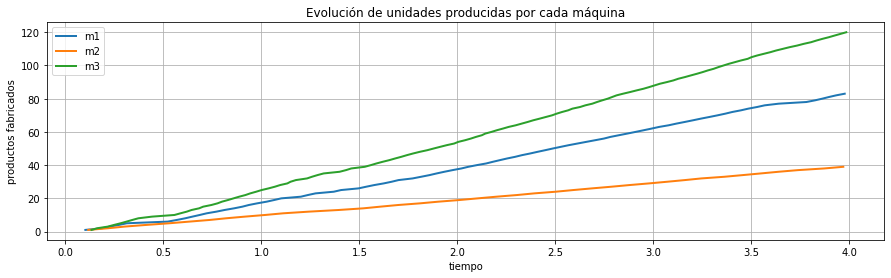

In [11]:
# Filtramos el tiempo en el que fue producida cada unidad y anotamos en otro array la cantidad acumulada en ese momento:
t_productos_m1 = log.loc[log['evento'] == 'm1_out', 'tiempo'].values
q_fabricada_m1 = np.array(range(1, len(t_productos_m1) + 1))

t_productos_m2 = log.loc[log['evento'] == 'm2_out', 'tiempo'].values
q_fabricada_m2 = np.array(range(1, len(t_productos_m2) + 1))

t_productos_m3 = log.loc[log['evento'] == 'm3_out', 'tiempo'].values
q_fabricada_m3 = np.array(range(1, len(t_productos_m3) + 1))

# Imprimimos los resultados de cantidad al tiempo final de la simulación:
print('\n ######### Cantidad de productos fabricados por máquina ###############')
print('Máquina 1: %0.3f' % q_fabricada_m1[-1])
print('Máquina 2: %0.3f' % q_fabricada_m2[-1]) 
print('Máquina 3: %0.3f' % q_fabricada_m3[-1])

# Ploteo de cantidad de productos fabricados en cada tiempo por cada máquina:
fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(t_productos_m1, q_fabricada_m1, label='m1', linewidth=2)
axs.plot(t_productos_m2, q_fabricada_m2, label='m2', linewidth=2) 
axs.plot(t_productos_m3, q_fabricada_m3, label='m3', linewidth=2)
axs.set_xlabel('tiempo')
axs.set_ylabel('productos fabricados')
axs.grid(True)
axs.legend()
axs.set_title('Evolución de unidades producidas por cada máquina')

En segundo lugar interesa saber el estado de las filas. Para ello imprimimos valores puntuales: cantidad media y cantidad máxima de unidades en la fila.
Por otro lado, realizamos un ploteo de la evolución de la cantidad de unidades en cada una de las filas. Esto nos permite encontrar anomalías en el balanceo de la línea y posibles cuellos de botella.


 ######### Stats de filas ###############


,cantidad media,cantidad máxima
# fila,,
0,1.829653,8
1,0.753428,2
2,0.312401,2


Text(0.5, 1.0, 'Evolución de cantidad de unidades en cada fila')

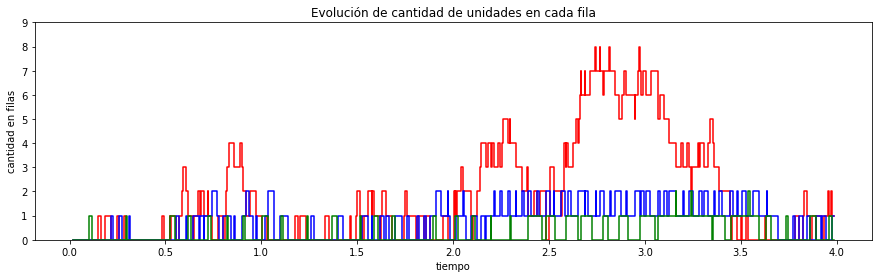

In [12]:
# Guardamos en un array las fracciones de tiempo asociadas a los eventos:
t_array = log['tiempo'].values

# Función para caclular el tiempo medio que un producto pasa en la fila:
def calcular_q_media_fila(estado_fila_array, t_array):
    tiempo_total = t_array[-1]
    t_entre_eventos = np.diff(np.insert(t_array, 0, 0)).transpose()
    return np.dot(estado_fila_array, t_entre_eventos) / tiempo_total

q_media_fila0 = calcular_q_media_fila(estado_fila0, t_array)
q_media_fila1 = calcular_q_media_fila(estado_fila1, t_array)
q_media_fila2 = calcular_q_media_fila(estado_fila2, t_array)

q_max_fila0 = max(estado_fila0)
q_max_fila1 = max(estado_fila1)
q_max_fila2 = max(estado_fila2)

print('\n ######### Stats de filas ###############')
fila_stats_df = pd.DataFrame({'# fila': [0, 1, 2],
                              'cantidad media': [q_media_fila0, q_media_fila1, q_media_fila2],
                              'cantidad máxima': [q_max_fila0, q_max_fila1, q_max_fila2]}).set_index('# fila')

display(HTML(fila_stats_df.to_html()))

# Ploteo de estado de filas en cada tiempo:
fig, axs= plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(15)

axs.step(t_array, estado_fila0, label='fila 0', color='r')
axs.step(t_array, estado_fila1, label='fila 1', color='b')
axs.step(t_array, estado_fila2, label='fila 2', color='g')
lims = max(q_max_fila0, q_max_fila1, q_max_fila2) + 1
axs.set_ylim([0, lims])
axs.set_xlabel('tiempo')
axs.set_ylabel('cantidad en filas')
axs.set_title('Evolución de cantidad de unidades en cada fila')

## Ideas sobre conclusiones, a completar en el curso:
* La media en la fila 0 indica un desbalance entre el banco de pruebas y el control. Existe mucha dispersión durante la simulación para la fila 0. Los valores de la fila 1 y 2 son más estables.
* Las tres máquinas están trabajando al máximo de su capacidad.
* No se tuvo en cuenta período de warm up.
* IMPORTANTE: La simulación no tuvo en cuenta el método de Monte Carlo y está sujeta al sesgo de uno de los caminos posibles.